In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import cv2


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
images = np.load('/content/drive/MyDrive/Colab Notebooks/images_proj.npy')
labels_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Labels_proj.csv')

In [ ]:
y = labels_df["Label"].values

In [ ]:
print("Images shape:", images.shape, images.dtype)
print("Labels shape:", y.shape, y.dtype)
print(labels_df.head())

Images shape: (631, 200, 200, 3) uint8
Labels shape: (631,) int64
   Label
0      1
1      1
2      1
3      1
4      1


In [ ]:
n, h, w, c = images.shape
print(f"Total images: {n}, Height: {h}, Width: {w}, Channels: {c}")
print("Unique labels:", np.unique(y))

Total images: 631, Height: 200, Width: 200, Channels: 3
Unique labels: [0 1]


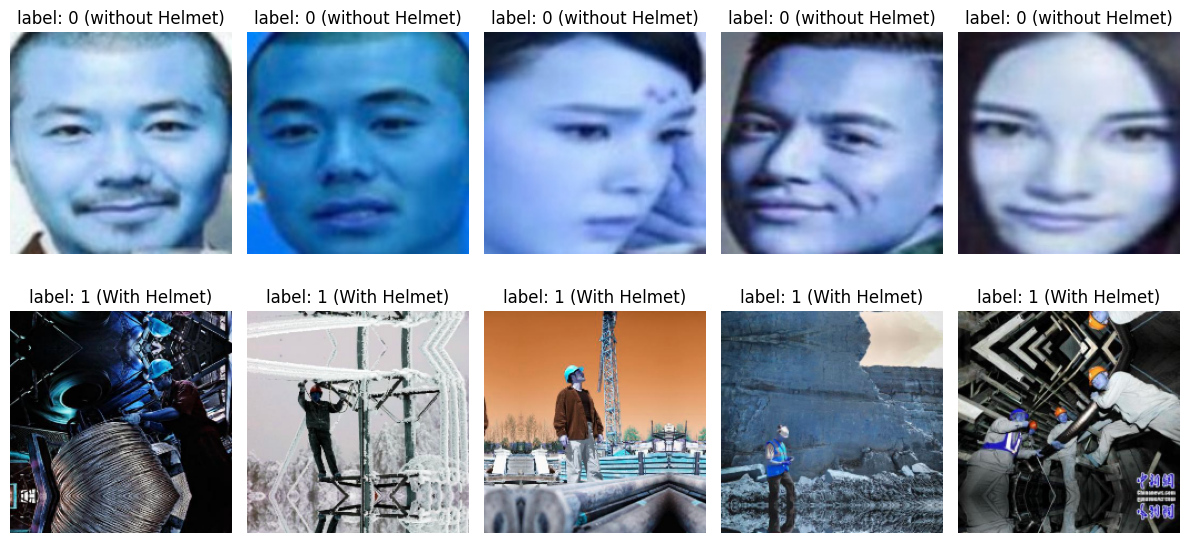

In [ ]:
label_map = {0: "without Helmet", 1: "With Helmet"}

def show_random_images_per_class(images, y, n_per_class=4):
    plt.figure(figsize=(12, 6))
    idx = 1

    for cls in sorted(np.unique(y)):
        cls_indices = np.where(y == cls)[0]
        sampled = np.random.choice(cls_indices, size=n_per_class, replace=False)

        for i in sampled:
            plt.subplot(len(np.unique(y)), n_per_class, idx)
            plt.imshow(images[i])
            plt.title(f"label: {y[i]} ({label_map[y[i]]})")
            plt.axis("off")
            idx += 1
    plt.tight_layout()
    plt.show()

show_random_images_per_class(images, y, n_per_class=5)


0    320
1    311
Name: count, dtype: int64


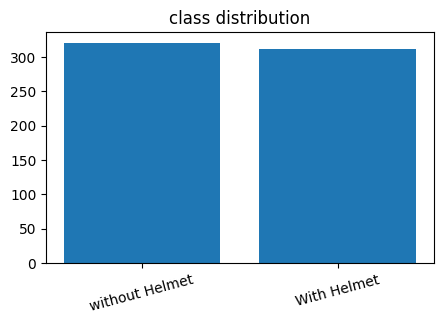

imbalance ratio (min/max): 0.972


In [ ]:
class_counts =pd.Series(y).value_counts().sort_index()
print(class_counts)

plt.figure(figsize=(5,3))
plt.bar([label_map[i] for i in class_counts.index], class_counts.values)
plt.title("class distribution")
plt.xticks(rotation=15)
plt.show()

imbalance_ratio = class_counts.min() / class_counts.max()
print("imbalance ratio (min/max):", round(imbalance_ratio,3))

pixel min: 0 max: 255 mean: 128.91237271526677


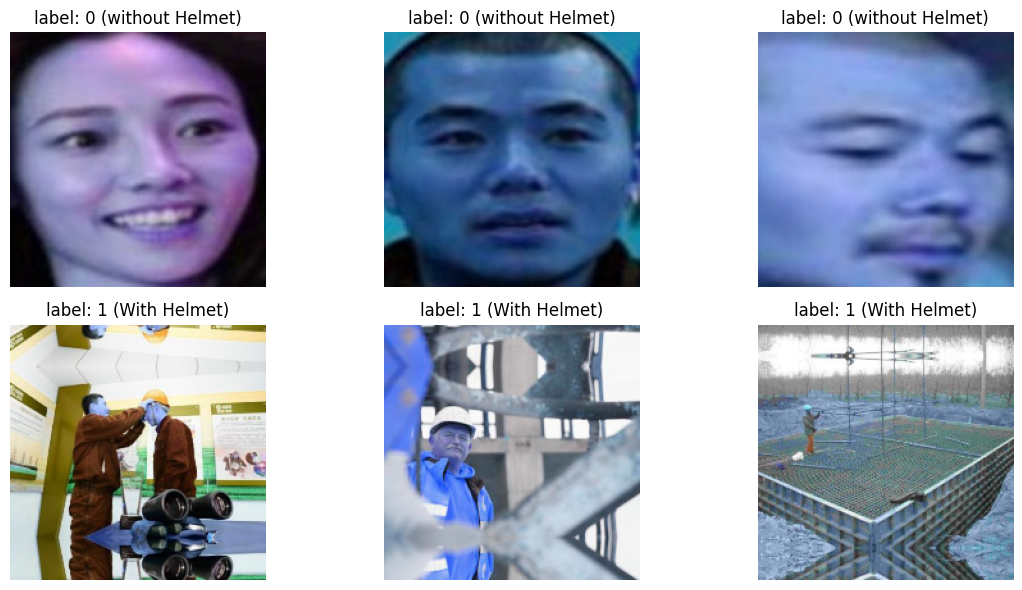

In [ ]:
print("pixel min:", images.min(), "max:", images.max(), "mean:", images.mean())

show_random_images_per_class(images, y, n_per_class=3)


EDA Observations:
1) Dataset is nearly balanced (320 vs 311), so no major class imbalance expected.
2) Images are 200x200x3 (RGB), consistent shape -> easy model input.
3) Real-world variation visible (backgrounds, lighting, angles, worker pose) -> augmentation & robust model helpful.
4) Raw pixel range is 0-255 -> normalization needed for neural nets.
"""

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, y, test_size=0.30, random_state= SEED, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print("Train:", X_train.shape, "Vale:", X_val.shape, "Test:", X_test.shape)


Train: (441, 200, 200, 3) Vale: (95, 200, 200, 3) Test: (95, 200, 200, 3)


Preprocessed images shape: (631, 200, 200, 3) uint8


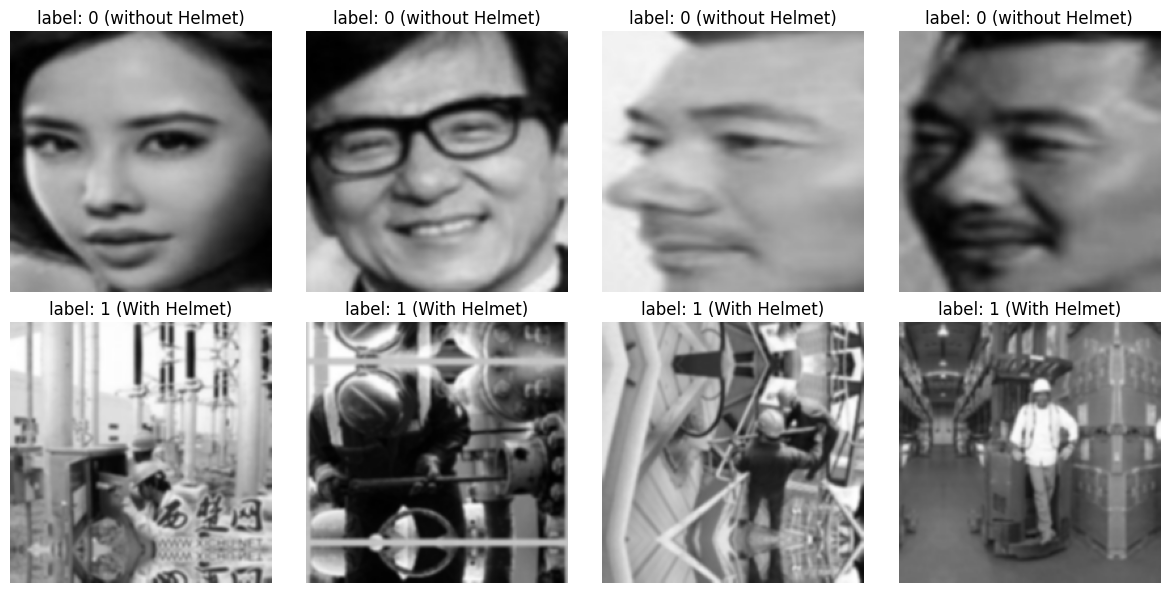

In [ ]:
def preprocess_images_two_steps(imgs):
    processed = []
    for img in imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_3ch = np.stack([gray, gray, gray], axis=-1)

        blur = cv2.GaussianBlur(gray_3ch, (5, 5), 0)
        processed.append(blur)
    return np.array(processed, dtype=np.uint8)

images_prep = preprocess_images_two_steps(images)
print("Preprocessed images shape:", images_prep.shape, images_prep.dtype)

show_random_images_per_class(images_prep, y, n_per_class=4)

In [ ]:
Xp_train, Xp_temp, yp_train, yp_temp = train_test_split(
    images_prep, y, test_size=0.30, random_state=SEED, stratify=y
)
Xp_val, Xp_test, yp_val, yp_test = train_test_split(
    Xp_temp, yp_temp, test_size=0.50, random_state=SEED, stratify=yp_temp
)

print("Prep:", Xp_train.shape, "Prep Val:", Xp_val.shape, "Prep Test:", Xp_test.shape)

Prep: (441, 200, 200, 3) Prep Val: (95, 200, 200, 3) Prep Test: (95, 200, 200, 3)


In [ ]:
X_train_n = X_train.astype("float32") / 255.0
X_val_n = X_val.astype("float32") / 255.0
X_test_n = X_test.astype("float32") / 255.0

Xp_train_n = Xp_train.astype("float32") / 255.0
Xp_val_n = Xp_val.astype("float32") / 255.0
Xp_test_n = Xp_test.astype("float32") / 255.0

print("Normalized range (orig):", X_train_n.min(), X_train_n.max())
print("normalized range (prep):", Xp_train_n.min(), Xp_train_n.max())

Normalized range (orig): 0.0 1.0
normalized range (prep): 0.0 1.0


Model Building

In [ ]:
def compile_and_train(model, Xtr, ytr, Xv, yv, epochs=15, batch_size=32):
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics = ["accuracy"]
    )
    callback = [
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights = True, mode="max")
    ]
    history = model.fit(
        Xtr, ytr,
        validation_data = (Xv, yv),
        epochs = epochs,
        batch_size = batch_size,
        callbacks = callback
    )
    train_loss, train_acc = model.evaluate(Xtr, ytr, verbose=0)
    val_loss, val_acc = model.evaluate(Xv, yv, verbose=0)
    return history, train_loss, train_acc, val_loss, val_acc

Model 1: Simple ANN with Image Flattening (Original)

In [ ]:
model1 = models.Sequential([
    layers.Input(shape=(200,200,3)),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

hist1, trL1, trA1, vL1, vA1 = compile_and_train(model1, X_train_n, y_train, X_val_n, y_val, epochs=15)
print("Model1 Train Acc:", trA1, "Val Acc:", vA1)


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step - accuracy: 0.5632 - loss: 26.2265 - val_accuracy: 0.7684 - val_loss: 5.3457
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 610ms/step - accuracy: 0.7341 - loss: 10.6097 - val_accuracy: 0.8421 - val_loss: 3.9577
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - accuracy: 0.8017 - loss: 4.9696 - val_accuracy: 0.8421 - val_loss: 3.8978
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 486ms/step - accuracy: 0.8310 - loss: 3.6456 - val_accuracy: 0.8526 - val_loss: 2.6376
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 604ms/step - accuracy: 0.8542 - loss: 2.0564 - val_accuracy: 0.8737 - val_loss: 2.0617
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 497ms/step - accuracy: 0.8536 - loss: 1.8507 - val_accuracy: 0.8947 - val_loss: 0.9269
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 592ms/step - accuracy: 0.8413 - loss: 1.6271 - val_accuracy: 0.8105 - val_loss: 2.5303
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 603ms/step - accuracy: 0.8700 - loss: 1.5356 - val_accurac

Model 2: Simple ANN with PREPROCESSED Images + Flattening

In [ ]:
model2 = models.Sequential([
    layers.Input(shape=(200,200,3)),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

hist2, trL2, trA2, vL2, vA2 = compile_and_train(model2, Xp_train_n, yp_train, Xp_val_n, yp_val, epochs=15)
print("Model2 Train Acc:", trA2, "Val Acc:", vA2)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 536ms/step - accuracy: 0.5901 - loss: 13.5553 - val_accuracy: 0.8421 - val_loss: 1.4189
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 597ms/step - accuracy: 0.7022 - loss: 4.9794 - val_accuracy: 0.8421 - val_loss: 1.8157
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 522ms/step - accuracy: 0.7227 - loss: 5.8793 - val_accuracy: 0.8737 - val_loss: 1.0059
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.7564 - loss: 2.7731 - val_accuracy: 0.8737 - val_loss: 1.4672
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 516ms/step - accuracy: 0.8127 - loss: 2.0827 - val_accuracy: 0.8947 - val_loss: 0.6954
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 614ms/step - accuracy: 0.8125 - loss: 1.2012 - val_accuracy: 0.8947 - val_loss: 0.6309
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 505ms/step - accuracy: 0.8625 - loss: 0.8090 - val_accuracy: 0.9053 - val_loss: 0.4423
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 599ms/step - accuracy: 0.8365 - loss: 0.8985 - val_accura

Model 3: Basic CNN (

In [ ]:
model3 = models.Sequential([
    layers.Input(shape=(200,200,3)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(1, activation="sigmoid")
])

hist3, trL3, trA3, vL3, vA3 = compile_and_train(model3, X_train_n, y_train, X_val_n, y_val, epochs=20)
print("Model3 Train Acc:", trA3, "Val Acc:", vA3)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.5697 - loss: 1.2070 - val_accuracy: 0.9053 - val_loss: 0.2850
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9466 - loss: 0.2096 - val_accuracy: 0.7368 - val_loss: 1.2058
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9378 - loss: 0.2350 - val_accuracy: 0.9895 - val_loss: 0.1003
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9987 - loss: 0.0239 - val_accuracy: 0.9895 - val_loss: 0.1147
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9826 - loss: 0.0492 - val_accuracy: 0.9895 - val_loss: 0.1359
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9938 - loss: 0.0378 - val_accuracy: 0.9895 - val_loss: 0.1603
Model3 Train Acc: 1.0 Val Acc: 0.9894737005233765


Model 4: VGG16 + FFNN

In [ ]:
vgg_base = VGG16(include_top=False, weights="imagenet", input_shape=(200,200,3))
vgg_base.trainable = False  # freeze

inputs = layers.Input(shape=(200,200,3))
x = vgg_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model4 = models.Model(inputs, outputs)

hist4, trL4, trA4, vL4, vA4 = compile_and_train(model4, X_train_n, y_train, X_val_n, y_val, epochs=15)
print("Model4 Train Acc:", trA4, "Val Acc:", vA4)


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 317s 23s/step - accuracy: 0.6033 - loss: 0.6368 - val_accuracy: 0.9895 - val_loss: 0.2925
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 332s 24s/step - accuracy: 0.9807 - loss: 0.2511 - val_accuracy: 1.0000 - val_loss: 0.1182
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 295s 21s/step - accuracy: 0.9974 - loss: 0.1093 - val_accuracy: 1.0000 - val_loss: 0.0586
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 232s 17s/step - accuracy: 1.0000 - loss: 0.0514 - val_accuracy: 1.0000 - val_loss: 0.0360
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 226s 16s/step - accuracy: 1.0000 - loss: 0.0354 - val_accuracy: 1.0000 - val_loss: 0.0255
Model4 Train Acc: 0.997732400894165 Val Acc: 1.0


Model 5: VGG16 + FFNN + Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

vgg_base2 = VGG16(include_top=False, weights="imagenet", input_shape=(200,200,3))
vgg_base2.trainable = False

inputs = layers.Input(shape=(200,200,3))
x = data_augmentation(inputs)
x = vgg_base2(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model5 = models.Model(inputs, outputs)

hist5, trL5, trA5, vL5, vA5 = compile_and_train(model5, X_train_n, y_train, X_val_n, y_val, epochs=20)
print("Model5 Train Acc:", trA5, "Val Acc:", vA5)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 233s 17s/step - accuracy: 0.5174 - loss: 0.7084 - val_accuracy: 1.0000 - val_loss: 0.3308
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 261s 17s/step - accuracy: 0.9643 - loss: 0.3141 - val_accuracy: 1.0000 - val_loss: 0.1394
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 263s 17s/step - accuracy: 0.9901 - loss: 0.1587 - val_accuracy: 1.0000 - val_loss: 0.0726
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 228s 17s/step - accuracy: 0.9994 - loss: 0.0858 - val_accuracy: 1.0000 - val_loss: 0.0433
Model5 Train Acc: 0.9886621236801147 Val Acc: 1.0



Model Observations :
- ANN(flatten) usually underperforms because it ignores spatial features.
- CNN should improve since it learns edges/textures and spatial patterns.
- VGG16 transfer learning typically performs best on small image datasets.
- Data augmentation often reduces overfitting and improves validation performance.


Model Performance Comparison and Final Model Selection

In [ ]:
results = pd.DataFrame([
    ["ANN_Original_Flatten", trA1, vA1, trL1, vL1],
    ["ANN_Preprocessed_Flatten", trA2, vA2, trL2, vL2],
    ["Basic_CNN", trA3, vA3, trL3, vL3],
    ["VGG16_FFNN", trA4, vA4, trL4, vL4],
    ["VGG16_FFNN_Aug", trA5, vA5, trL5, vL5],
], columns=["Model", "Train_Acc", "Val_Acc", "Train_Loss", "Val_Loss"])

results.sort_values("Val_Acc", ascending=False)

,Model,Train_Acc,Val_Acc,Train_Loss,Val_Loss
4,VGG16_FFNN_Aug,0.988662,1.000000,0.327795,0.330771
3,VGG16_FFNN,0.997732,1.000000,0.114136,0.118236
2,Basic_CNN,1.000000,0.989474,0.029810,0.100333
1,ANN_Preprocessed_Flatten,0.934240,0.915789,0.160495,0.251232
0,ANN_Original_Flatten,0.943311,0.894737,0.463279,0.926944


Choose best model + Test set evaluation

In [ ]:
best_model_name = results.sort_values("Val_Acc", ascending=False).iloc[0]["Model"]
print("Best Model by Val Accuracy:", best_model_name)

model_dict = {
    "ANN_Original_Flatten": model1,
    "ANN_Preprocessed_Flatten": model2,
    "Basic_CNN": model3,
    "VGG16_FFNN": model4,
    "VGG16_FFNN_Aug": model5
}
best_model = model_dict[best_model_name]

test_loss, test_acc = best_model.evaluate(X_test_n, y_test, verbose=0)
print("Test Accuracy:", test_acc)

y_pred_prob = best_model.predict(X_test_n).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred, target_names=[label_map[0], label_map[1]]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best Model by Val Accuracy: VGG16_FFNN_Aug
Test Accuracy: 0.9894737005233765
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 13s/step
                precision    recall  f1-score   support

without Helmet       0.98      1.00      0.99        48
   With Helmet       1.00      0.98      0.99        47

      accuracy                           0.99        95
     macro avg       0.99      0.99      0.99        95
  weighted avg       0.99      0.99      0.99        95

Confusion Matrix:
 [[48  0]
 [ 1 46]]
